# **Anomoly Detection using OneClass SVM and K-NN**

This notebook goes through the implementation of the OneClass SVM and K-NN to the dataset produced using the data generator. The code is run on 6 generated versions produced from the generator through varying outliers_fraction and num_clusters. The F-score, precision, and recall will also be concluded from both these methods. We will first be implementing OneClass SVM for all variations of the generated data set and then doing the same for K NN, concluding with an analysis on all the values obtained.

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs, make_moons
from matplotlib.pyplot import figure
import numpy as np

# **Data Generator**

Implementation of the Data generator provided in order to obtain the first data set we will use to implement bothe OnceClass SVM as well as K NN. The first data set me generate will have 0.1 for the outliers_fraction variable and 10 for the num_clusters variable.

In [117]:
n_samples = 2000

# modify these settings to obtain different combinations of high density areas (clusters) and outliers
outliers_fraction = 0.1    ## values to use: 0.01, 0.05, 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
num_clusters = 10
stdev = 1
n_features = 2

print("total samples: {s} outliers: {o}%, outliers expected:{ot}, inliers:{i}".format(s=n_samples, o=outliers_fraction, ot=n_outliers, i=n_inliers))
print("blobs: centers: {c}, samples = {n}, std dev: {std}".format(c=num_clusters, n=n_inliers, std=stdev))

total samples: 2000 outliers: 0.1%, outliers expected:200, inliers:1800
blobs: centers: 10, samples = 1800, std dev: 1


In [118]:
samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

print("clustered samples: {s}".format(s=len(samples)))

## range of samples points -- used to determine the boundaries for outliers generation
boost = 1.1   ## extends the range covered by the clusters
xmin = min(samples[:,0]) 
xmax = max(samples[:,0]) 
ymin = min(samples[:,1]) 
ymax = max(samples[:,1]) 
print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

low = min(xmin, ymin) * boost
high = max(xmax, ymax) * boost
print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

# Add n_outlier outliers, n_features each 
rng = np.random.RandomState(42)
outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
print("number of outliers produced: {o}".format(o=len(outliers)))

## some of the outliers are within clusters. 
## we use the distance from centers to remove some of the outliers, as those will never be detected
distances = dict()
out = dict()
i=0
for o in outliers:
    mindist = 1000000
    for c in centers:
        dist = np.linalg.norm(o-c)  ## euclidean distance
        if dist < mindist:
            mindist = dist
    out[i] = o
    distances[i]= mindist
    i = i + 1

distarray = np.asarray(list(distances.values()))
meandist  = np.mean(distarray)
vardist   = np.std(distarray)

print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

## remove points that are too close to the centers

alpha = 1.2 ## larger than1 removes points that are more distant from centroids
removed = 0
for i in range(len(outliers)):
    if distances[i] < meandist-vardist * alpha:
        print("removing {d:.2f}".format(d=distances[i]))
        out.pop(i)
        removed = removed + 1

finalOutliers_10_1 = np.asarray(list(out.values()))
print("removed {r} outliers. {n} remaining outliers ".format(r=removed, n=len(finalOutliers)))

clustered samples: 1800
xmin: -12.41, xmax: 11.95
ymin: -10.54, ymax: 10.83
low, high for outliers: -13.65, 13.15
number of outliers produced: 200
outliers distances from centres: mean 4.62, var 2.57
removing 1.50
removing 0.51
removing 0.48
removing 1.23
removing 1.46
removing 1.22
removing 1.14
removing 1.25
removing 1.36
removing 1.29
removing 0.59
removing 1.37
removing 1.51
removing 0.49
removing 0.88
removing 1.20
removing 1.44
removing 0.69
removing 1.07
removing 0.20
removing 1.23
removed 21 outliers. 91 remaining outliers 


Text(0.5, 1.0, 'clusters with outliers after removing points close to cluster centers')

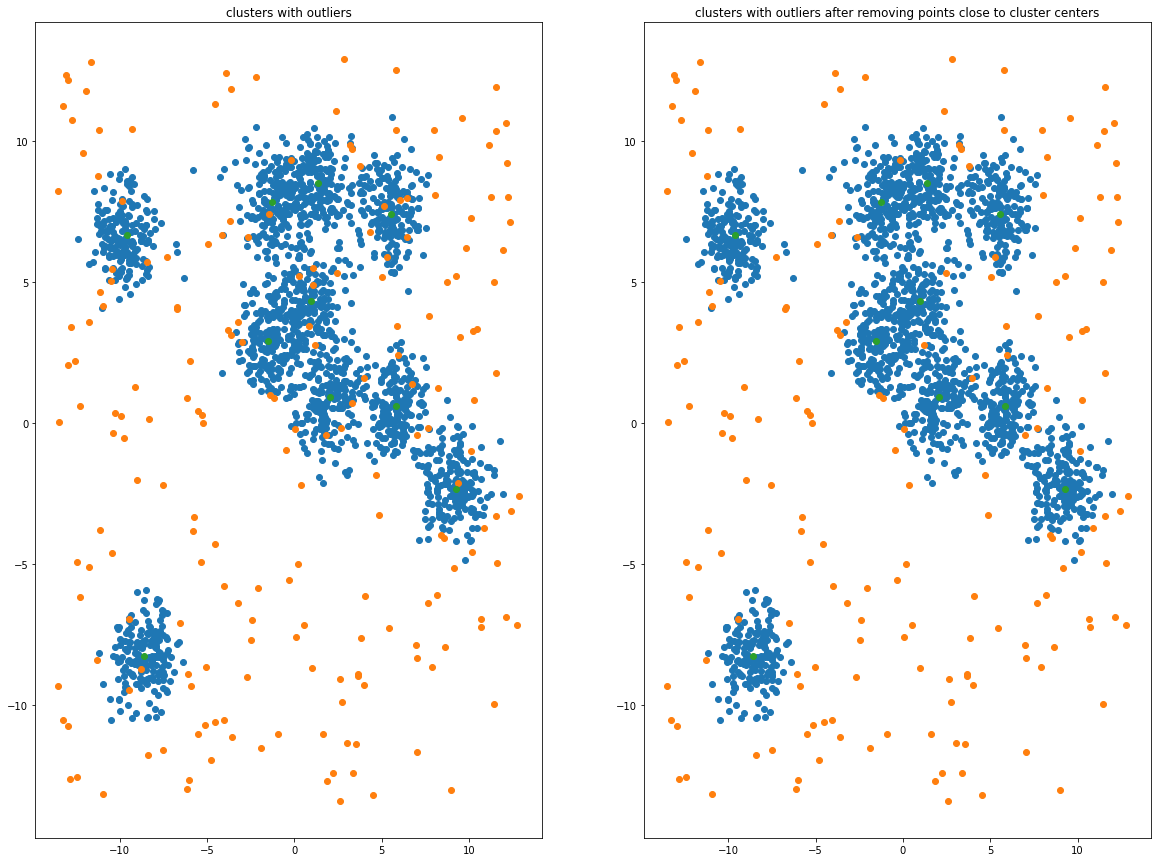

In [119]:
fig, ax = plt.subplots(1,2, figsize=(20,15))

ax[0].scatter(samples[:,0], samples[:,1])
ax[0].scatter(outliers[:,0], outliers[:,1])
ax[0].scatter(centers[:,0], centers[:,1])
ax[0].set_title("clusters with outliers")

    
ax[1].scatter(samples[:,0], samples[:,1])
ax[1].scatter(finalOutliers_10_1[:,0], finalOutliers_10_1[:,1])
ax[1].scatter(centers[:,0], centers[:,1])
ax[1].set_title("clusters with outliers after removing points close to cluster centers")

In [120]:
full_set_10_1 = np.concatenate([samples, finalOutliers_10_1], axis=0)

# **OneClassSVM Implementation**

Implementing OneClassSVM from the scikit learn in order to detect outliers, which will eventually be compared to the groundtruth dataset produced by the generator. OneClassSVM utilises support vector machine which utilises lines to seperate one class from another. OneClass SVM is an algorythm designed for novelty detection.

In [132]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
from numpy import quantile, where, random

In [133]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
svm.fit(full_set_10_1)
pred = svm.fit_predict(full_set_10_1)
scores = svm.score_samples(full_set_10_1)
## setting threshold value as 0.03
thresh = quantile(scores, 0.03)
index = where(scores<=thresh)
values_10_1 = full_set_10_1[index]

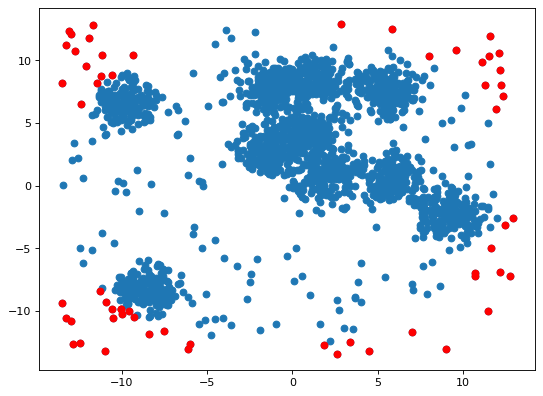

In [134]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(full_set_10_1[:,0], full_set_10_1[:,1])
plt.scatter(values_10_1[:,0], values_10_1[:,1], color='r')
plt.show()

# **Calculating and concluding the precision, recall and F1- meansure for OneClass SVM**

The values obtained for the required truePositive, falsePositive and falseNegative were obtained through iterating and comparing the outliers obtained to the ground truth outliers provided by the generator. They were then used for the necessary calculations to obtain the required values.

In [135]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in values_10_1:
  if row in finalOutliers_10_1:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0




print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))


truePositive: 49
falsePositive: 11


In [136]:
match = 0
for row in finalOutliers_10_1:
  if row in values_10_1:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))


falseNegative: 0


In [137]:
SVM_10_1Precision = truePositive/(truePositive+falsePositive)
SVM_10_1Recall = truePositive/(truePositive+falseNegative)
SVM_10_1F1 = 2*((SVM_10_1Precision*SVM_10_1Recall)/(SVM_10_1Precision+SVM_10_1Recall))
print ("SVM_10_1Precision: {x}".format(x=SVM_10_1Precision))
print ("SVM_10_1Recall: {x}".format(x=SVM_10_1Recall))
print ("SVM_10_1F1: {x}".format(x=SVM_10_1F1))

SVM_10_1Precision: 0.8166666666666667
SVM_10_1Recall: 1.0
SVM_10_1F1: 0.8990825688073394


# **Implementing OneCalss SVM on Other data sets**

implementing OneCalss SVM on the data sets generated through varying the parameters. We will also calculate the precision, recall and F1- meansure for these implementations as well in order to clealry analyse the difference in performance.

In [209]:
n_samples = 2000

# modify these settings to obtain different combinations of high density areas (clusters) and outliers
outliers_fraction = 0.01    ## values to use: 0.01, 0.05, 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
num_clusters = 10
stdev = 1
n_features = 2

samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

print("clustered samples: {s}".format(s=len(samples)))

## range of samples points -- used to determine the boundaries for outliers generation
boost = 1.1   ## extends the range covered by the clusters
xmin = min(samples[:,0]) 
xmax = max(samples[:,0]) 
ymin = min(samples[:,1]) 
ymax = max(samples[:,1]) 
print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

low = min(xmin, ymin) * boost
high = max(xmax, ymax) * boost
print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

# Add n_outlier outliers, n_features each 
rng = np.random.RandomState(42)
outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
print("number of outliers produced: {o}".format(o=len(outliers)))

## some of the outliers are within clusters. 
## we use the distance from centers to remove some of the outliers, as those will never be detected
distances = dict()
out = dict()
i=0
for o in outliers:
    mindist = 1000000
    for c in centers:
        dist = np.linalg.norm(o-c)  ## euclidean distance
        if dist < mindist:
            mindist = dist
    out[i] = o
    distances[i]= mindist
    i = i + 1

distarray = np.asarray(list(distances.values()))
meandist  = np.mean(distarray)
vardist   = np.std(distarray)

print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

## remove points that are too close to the centers

alpha = 1.2 ## larger than1 removes points that are more distant from centroids
removed = 0
for i in range(len(outliers)):
    if distances[i] < meandist-vardist * alpha:
        out.pop(i)
        removed = removed + 1

finalOutliers_10_01 = np.asarray(list(out.values()))
full_set_10_01 = np.concatenate([samples, finalOutliers_10_01], axis=0)

clustered samples: 1980
xmin: -12.60, xmax: 11.89
ymin: -10.52, ymax: 10.77
low, high for outliers: -13.86, 13.08
number of outliers produced: 20
outliers distances from centres: mean 5.09, var 3.01


In [222]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
svm.fit(full_set_10_01)
pred = svm.fit_predict(full_set_10_01)
scores = svm.score_samples(full_set_10_01)
## setting threshold value as 0.004
thresh = quantile(scores, 0.004)
index = where(scores<=thresh)
values_10_01 = full_set_10_01[index]


In [223]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in values_10_01:
  if row in finalOutliers_10_01:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 5
falsePositive: 3


In [224]:
match = 0
for row in finalOutliers_10_01:
  if row in values_10_01:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [225]:
SVM_10_01Precision = truePositive/(truePositive+falsePositive)
SVM_10_01Recall = truePositive/(truePositive+falseNegative)
SVM_10_01F1 = 2*((SVM_10_01Precision*SVM_10_01Recall)/(SVM_10_01Precision+SVM_10_01Recall))
print ("SVM_10_01Precision: {x}".format(x=SVM_10_01Precision))
print ("SVM_10_01Recall: {x}".format(x=SVM_10_01Recall))
print ("SVM_10_01F1: {x}".format(x=SVM_10_01F1))

SVM_10_01Precision: 0.625
SVM_10_01Recall: 1.0
SVM_10_01F1: 0.7692307692307693


In [161]:
n_samples = 2000

# modify these settings to obtain different combinations of high density areas (clusters) and outliers
outliers_fraction = 0.05    ## values to use: 0.01, 0.05, 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
num_clusters = 10
stdev = 1
n_features = 2

samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

print("clustered samples: {s}".format(s=len(samples)))

## range of samples points -- used to determine the boundaries for outliers generation
boost = 1.1   ## extends the range covered by the clusters
xmin = min(samples[:,0]) 
xmax = max(samples[:,0]) 
ymin = min(samples[:,1]) 
ymax = max(samples[:,1]) 
print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

low = min(xmin, ymin) * boost
high = max(xmax, ymax) * boost
print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

# Add n_outlier outliers, n_features each 
rng = np.random.RandomState(42)
outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
print("number of outliers produced: {o}".format(o=len(outliers)))

## some of the outliers are within clusters. 
## we use the distance from centers to remove some of the outliers, as those will never be detected
distances = dict()
out = dict()
i=0
for o in outliers:
    mindist = 1000000
    for c in centers:
        dist = np.linalg.norm(o-c)  ## euclidean distance
        if dist < mindist:
            mindist = dist
    out[i] = o
    distances[i]= mindist
    i = i + 1

distarray = np.asarray(list(distances.values()))
meandist  = np.mean(distarray)
vardist   = np.std(distarray)

print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

## remove points that are too close to the centers

alpha = 1.2 ## larger than1 removes points that are more distant from centroids
removed = 0
for i in range(len(outliers)):
    if distances[i] < meandist-vardist * alpha:
        out.pop(i)
        removed = removed + 1

finalOutliers_10_05 = np.asarray(list(out.values()))
full_set_10_05 = np.concatenate([samples, finalOutliers_10_05], axis=0)

clustered samples: 1900
xmin: -11.91, xmax: 11.89
ymin: -10.54, ymax: 10.83
low, high for outliers: -13.10, 13.08
number of outliers produced: 100
outliers distances from centres: mean 4.55, var 2.34


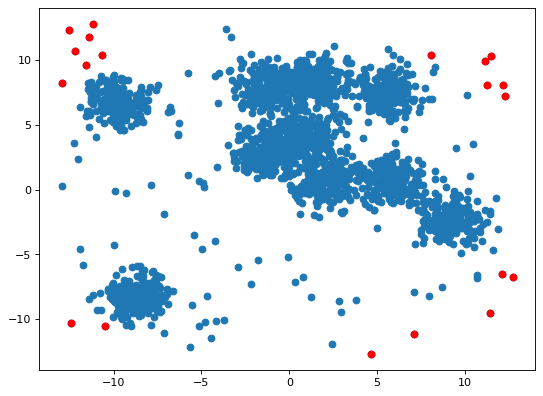

In [171]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
svm.fit(full_set_10_05)
pred = svm.fit_predict(full_set_10_05)
scores = svm.score_samples(full_set_10_05)
## setting threshold value as 0.01
thresh = quantile(scores, 0.01)
index = where(scores<=thresh)
values_10_05 = full_set_10_05[index]


In [172]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in values_10_05:
  if row in finalOutliers_10_05:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 19
falsePositive: 1


In [173]:
match = 0
for row in finalOutliers_10_05:
  if row in values_10_05:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [174]:
SVM_10_05Precision = truePositive/(truePositive+falsePositive)
SVM_10_05Recall = truePositive/(truePositive+falseNegative)
SVM_10_05F1 = 2*((SVM_10_05Precision*SVM_10_05Recall)/(SVM_10_05Precision+SVM_10_05Recall))
print ("SVM_10_05Precision: {x}".format(x=SVM_10_05Precision))
print ("SVM_10_05Recall: {x}".format(x=SVM_10_05Recall))
print ("SVM_10_05F1: {x}".format(x=SVM_10_05F1))

SVM_10_05Precision: 0.95
SVM_10_05Recall: 1.0
SVM_10_05F1: 0.9743589743589743


In [177]:
n_samples = 2000

# modify these settings to obtain different combinations of high density areas (clusters) and outliers
outliers_fraction = 0.1    ## values to use: 0.01, 0.05, 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
num_clusters = 5
stdev = 1
n_features = 2

samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

print("clustered samples: {s}".format(s=len(samples)))

## range of samples points -- used to determine the boundaries for outliers generation
boost = 1.1   ## extends the range covered by the clusters
xmin = min(samples[:,0]) 
xmax = max(samples[:,0]) 
ymin = min(samples[:,1]) 
ymax = max(samples[:,1]) 
print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

low = min(xmin, ymin) * boost
high = max(xmax, ymax) * boost
print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

# Add n_outlier outliers, n_features each 
rng = np.random.RandomState(42)
outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
print("number of outliers produced: {o}".format(o=len(outliers)))

## some of the outliers are within clusters. 
## we use the distance from centers to remove some of the outliers, as those will never be detected
distances = dict()
out = dict()
i=0
for o in outliers:
    mindist = 1000000
    for c in centers:
        dist = np.linalg.norm(o-c)  ## euclidean distance
        if dist < mindist:
            mindist = dist
    out[i] = o
    distances[i]= mindist
    i = i + 1

distarray = np.asarray(list(distances.values()))
meandist  = np.mean(distarray)
vardist   = np.std(distarray)

print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

## remove points that are too close to the centers

alpha = 1.2 ## larger than1 removes points that are more distant from centroids
removed = 0
for i in range(len(outliers)):
    if distances[i] < meandist-vardist * alpha:
        out.pop(i)
        removed = removed + 1

finalOutliers_5_1 = np.asarray(list(out.values()))
full_set_5_1 = np.concatenate([samples, finalOutliers_5_1], axis=0)

clustered samples: 1800
xmin: -4.64, xmax: 13.07
ymin: -5.05, ymax: 10.17
low, high for outliers: -5.55, 14.38
number of outliers produced: 200
outliers distances from centres: mean 5.35, var 3.47


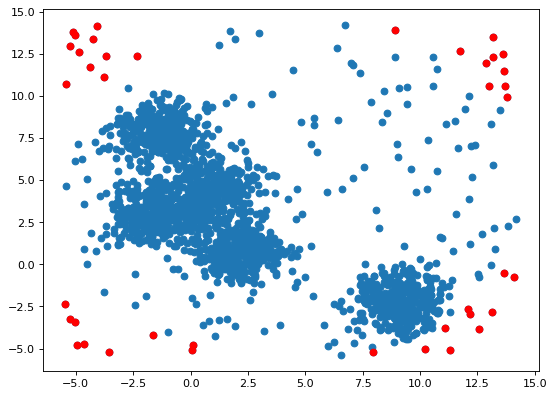

In [186]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
svm.fit(full_set_5_1)
pred = svm.fit_predict(full_set_5_1)
scores = svm.score_samples(full_set_5_1)
## setting threshold value as 0.02
thresh = quantile(scores, 0.02)
index = where(scores<=thresh)
values_5_1 = full_set_5_1[index]



In [187]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in values_5_1:
  if row in finalOutliers_5_1:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 35
falsePositive: 5


In [188]:
match = 0
for row in finalOutliers_5_1:
  if row in values_5_1:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [189]:
SVM_5_1Precision = truePositive/(truePositive+falsePositive)
SVM_5_1Recall = truePositive/(truePositive+falseNegative)
SVM_5_1F1 = 2*((SVM_5_1Precision*SVM_5_1Recall)/(SVM_5_1Precision+SVM_5_1Recall))
print ("SVM_5_1Precision: {x}".format(x=SVM_5_1Precision))
print ("SVM_5_1Recall: {x}".format(x=SVM_5_1Recall))
print ("SVM_5_1F1: {x}".format(x=SVM_5_1F1))

SVM_5_1Precision: 0.875
SVM_5_1Recall: 1.0
SVM_5_1F1: 0.9333333333333333


In [226]:
n_samples = 2000

# modify these settings to obtain different combinations of high density areas (clusters) and outliers
outliers_fraction = 0.01    ## values to use: 0.01, 0.05, 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
num_clusters = 5
stdev = 1
n_features = 2

samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

print("clustered samples: {s}".format(s=len(samples)))

## range of samples points -- used to determine the boundaries for outliers generation
boost = 1.1   ## extends the range covered by the clusters
xmin = min(samples[:,0]) 
xmax = max(samples[:,0]) 
ymin = min(samples[:,1]) 
ymax = max(samples[:,1]) 
print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

low = min(xmin, ymin) * boost
high = max(xmax, ymax) * boost
print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

# Add n_outlier outliers, n_features each 
rng = np.random.RandomState(42)
outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
print("number of outliers produced: {o}".format(o=len(outliers)))

## some of the outliers are within clusters. 
## we use the distance from centers to remove some of the outliers, as those will never be detected
distances = dict()
out = dict()
i=0
for o in outliers:
    mindist = 1000000
    for c in centers:
        dist = np.linalg.norm(o-c)  ## euclidean distance
        if dist < mindist:
            mindist = dist
    out[i] = o
    distances[i]= mindist
    i = i + 1

distarray = np.asarray(list(distances.values()))
meandist  = np.mean(distarray)
vardist   = np.std(distarray)

print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

## remove points that are too close to the centers

alpha = 1.2 ## larger than1 removes points that are more distant from centroids
removed = 0
for i in range(len(outliers)):
    if distances[i] < meandist-vardist * alpha:
        out.pop(i)
        removed = removed + 1

finalOutliers_5_01 = np.asarray(list(out.values()))
full_set_5_01 = np.concatenate([samples, finalOutliers_5_01], axis=0)

clustered samples: 1980
xmin: -4.64, xmax: 12.15
ymin: -5.72, ymax: 10.20
low, high for outliers: -6.30, 13.37
number of outliers produced: 20
outliers distances from centres: mean 4.73, var 2.60


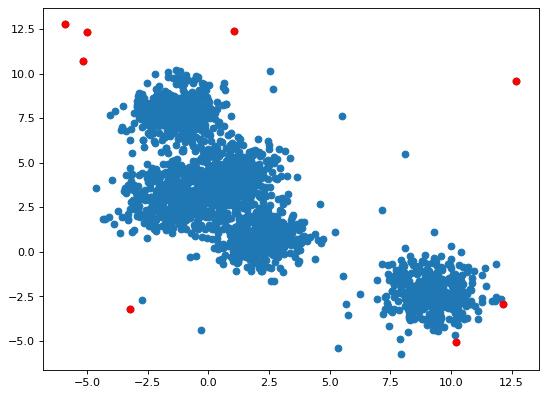

In [227]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
svm.fit(full_set_5_01)
pred = svm.fit_predict(full_set_5_01)
scores = svm.score_samples(full_set_5_01)
## setting threshold value as 0.004
thresh = quantile(scores, 0.004)
index = where(scores<=thresh)
values_5_01 = full_set_5_01[index]



In [228]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in values_5_01:
  if row in finalOutliers_5_01:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 6
falsePositive: 2


In [229]:
match = 0
for row in finalOutliers_5_01:
  if row in values_5_01:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [230]:
SVM_5_01Precision = truePositive/(truePositive+falsePositive)
SVM_5_01Recall = truePositive/(truePositive+falseNegative)
SVM_5_01F1 = 2*((SVM_5_01Precision*SVM_5_01Recall)/(SVM_5_01Precision+SVM_5_01Recall))
print ("SVM_5_01Precision: {x}".format(x=SVM_5_01Precision))
print ("SVM_5_01Recall: {x}".format(x=SVM_5_01Recall))
print ("SVM_5_01F1: {x}".format(x=SVM_5_01F1))

SVM_5_01Precision: 0.75
SVM_5_01Recall: 1.0
SVM_5_01F1: 0.8571428571428571


In [232]:
n_samples = 2000

# modify these settings to obtain different combinations of high density areas (clusters) and outliers
outliers_fraction = 0.05    ## values to use: 0.01, 0.05, 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
num_clusters = 5
stdev = 1
n_features = 2

samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

print("clustered samples: {s}".format(s=len(samples)))

## range of samples points -- used to determine the boundaries for outliers generation
boost = 1.1   ## extends the range covered by the clusters
xmin = min(samples[:,0]) 
xmax = max(samples[:,0]) 
ymin = min(samples[:,1]) 
ymax = max(samples[:,1]) 
print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

low = min(xmin, ymin) * boost
high = max(xmax, ymax) * boost
print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

# Add n_outlier outliers, n_features each 
rng = np.random.RandomState(42)
outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
print("number of outliers produced: {o}".format(o=len(outliers)))

## some of the outliers are within clusters. 
## we use the distance from centers to remove some of the outliers, as those will never be detected
distances = dict()
out = dict()
i=0
for o in outliers:
    mindist = 1000000
    for c in centers:
        dist = np.linalg.norm(o-c)  ## euclidean distance
        if dist < mindist:
            mindist = dist
    out[i] = o
    distances[i]= mindist
    i = i + 1

distarray = np.asarray(list(distances.values()))
meandist  = np.mean(distarray)
vardist   = np.std(distarray)

print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

## remove points that are too close to the centers

alpha = 1.2 ## larger than1 removes points that are more distant from centroids
removed = 0
for i in range(len(outliers)):
    if distances[i] < meandist-vardist * alpha:
        out.pop(i)
        removed = removed + 1

finalOutliers_5_05 = np.asarray(list(out.values()))
full_set_5_05 = np.concatenate([samples, finalOutliers_5_05], axis=0)

clustered samples: 1900
xmin: -4.64, xmax: 13.07
ymin: -5.72, ymax: 10.20
low, high for outliers: -6.30, 14.38
number of outliers produced: 100
outliers distances from centres: mean 5.24, var 3.30


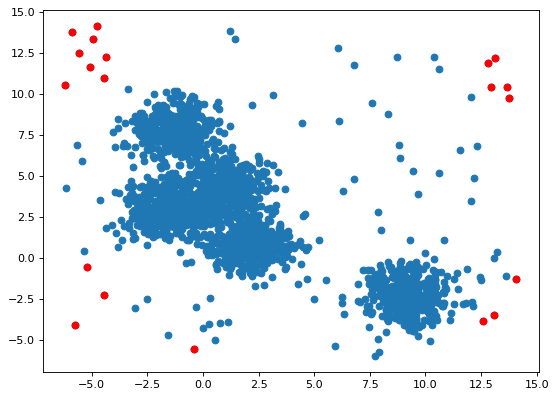

In [245]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
svm.fit(full_set_5_05)
pred = svm.fit_predict(full_set_5_05)
scores = svm.score_samples(full_set_5_05)
## setting threshold value as 0.01
thresh = quantile(scores, 0.01)
index = where(scores<=thresh)
values_5_05 = full_set_5_05[index]



In [246]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in values_5_05:
  if row in finalOutliers_5_05:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 19
falsePositive: 1


In [247]:
match = 0
for row in finalOutliers_5_05:
  if row in values_5_05:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [248]:
SVM_5_05Precision = truePositive/(truePositive+falsePositive)
SVM_5_05Recall = truePositive/(truePositive+falseNegative)
SVM_5_05F1 = 2*((SVM_5_05Precision*SVM_5_05Recall)/(SVM_5_05Precision+SVM_5_05Recall))
print ("SVM_5_05Precision: {x}".format(x=SVM_5_05Precision))
print ("SVM_5_05Recall: {x}".format(x=SVM_5_05Recall))
print ("SVM_5_05F1: {x}".format(x=SVM_5_05F1))

SVM_5_05Precision: 0.95
SVM_5_05Recall: 1.0
SVM_5_05F1: 0.9743589743589743


# **Implementing K-NN**

Implementing K Nearest Neighbor approach to the dataset generated in order to detect outliers. A script is written that applies K NN to the dataset utilising Euclidean as the distance function. A decision threshold was also decided upon that divides the inliers from the outliers to be detected. The K NN implementation is based upon the usage of threshold values. Data points beyond these values are considered outliers. 

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

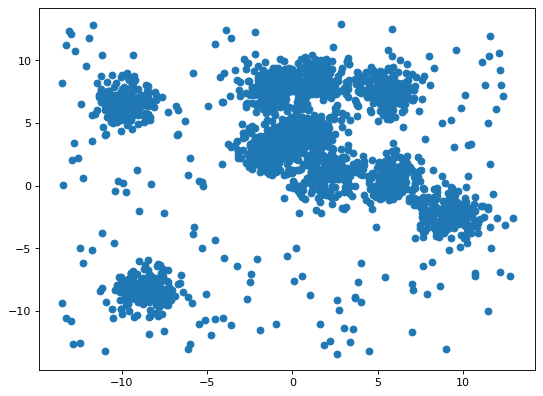

In [85]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(full_set_10_1[:,0], full_set_10_1[:,1])

# **Euclidean Distancet**

Implementing a function that measure Euclidean distance as this is required in order to measure the distance between points and discern between outliers and inliers. Euclidean distance can be calculated byt the following formula:

**Euclidean Distance = sqrt(sum i to N (x1_i – x2_i)^2)**

In [86]:
from math import sqrt
## function that calculates the Euclidean distance, to be utilised in get_neighbors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

# **Neighbours**

Defined a function that includes the implementation of the Euclidean Distance function in order to obtain the distance of a point from its neighbors. This includes the distance of it from itself, anotated by 0. The function takes the number of neighbours as one of its parameters. K neighbors are obtained by using distance function defined above on all points against the others. The neighbors are then appended to a list.

In [87]:
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(test_row, train_row)
		distances.append((dist))
	distances.sort()
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i])
	return neighbors

# **Neighbour Distance**

Utilized the mean function from the statistics library to obtain the mean of the distances obtained from the get neighbor function. This will later be compared to our decision threshold in order to determine outliers.

In [88]:
from statistics import mean
full_set_10_1.tolist()
full_set_10_1
neighbors = list()
for i in range(len(full_set_10_1)):

  neighbors.append((i,get_neighbors(full_set_10_1, full_set_10_1[i], 3),mean(get_neighbors(full_set_10_1, full_set_10_1[i], 3))))
  
for neighbor in neighbors:
    print(neighbor)

(0, [0.0, 0.23170504415254778, 0.332712289120791], 0.18813911109111292)
(1, [0.0, 0.14329692401350633, 0.23818879344790542], 0.12716190582047057)
(2, [0.0, 0.061394141222204296, 0.10920738521698722], 0.056867175479730504)
(3, [0.0, 0.2686910873647295, 0.2792068655097378], 0.18263265095815576)
(4, [0.0, 0.07443893705936934, 0.15230835851116345], 0.07558243185684427)
(5, [0.0, 0.11578233022264488, 0.12136962639405698], 0.07905065220556728)
(6, [0.0, 0.20015036275420084, 0.26315981318464793], 0.15443672531294958)
(7, [0.0, 0.06649389725260374, 0.14237665206813147], 0.06962351644024507)
(8, [0.0, 0.06043697915753781, 0.15051469281206803], 0.07031722398986862)
(9, [0.0, 0.06669475935537011, 0.12083894578902792], 0.06251123504813268)
(10, [0.0, 0.15405410258647867, 0.17301283514402882], 0.10902231257683583)
(11, [0.0, 0.3067440080734406, 0.31476364138753354], 0.20716921648699138)
(12, [0.0, 0.06263373006026102, 0.1445100536239012], 0.06904792789472074)
(13, [0.0, 0.12064745685997838, 0.12300

# **Outliers**

Itterated through the neighbours list and compared the mean distance of each point to the threshold valued decided. Through this, the outliers were decided upon and appended to a new list.

In [95]:
outliers = list()
for i in range(len(full_set_10_1)):
  ##distance threshold value set to 0.5
    if(neighbors[i][2] > 0.5) :
        outliers.append(i)


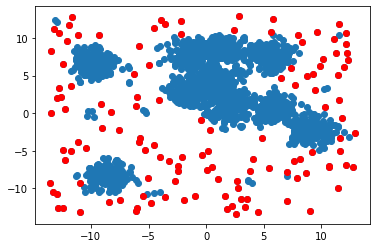

In [96]:
outlier_values_10_1 = full_set_10_1[outliers]
plt.scatter(full_set_10_1[:,0], full_set_10_1[:,1])
plt.scatter(outlier_values_10_1[:,0], outlier_values_10_1[:,1], color='r')
plt.show()

# **Calculating and concluding the precision, recall and F1- meansure for K NN**

The values obtained for the required truePositive, falsePositive and falseNegative were obtained through iterating and comparing the outliers obtained to the ground truth outliers provided by the generator. They were then used for the necessary calculations to obtain the required values.

In [97]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in outlier_values_10_1:
  if row in finalOutliers_10_1:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 116
falsePositive: 10


In [98]:
match = 0
for row in finalOutliers_10_1:
  if row in outlier_values_10_1:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [99]:
KNN_10_1Precision = truePositive/(truePositive+falsePositive)
KNN_10_1Recall = truePositive/(truePositive+falseNegative)
KNN_10_1F1 = 2*((KNN_10_1Precision*KNN_10_1Recall)/(KNN_10_1Precision+KNN_10_1Recall))
print ("KNN_10_1Precision: {x}".format(x=KNN_10_1Precision))
print ("KNN_10_1Recall: {x}".format(x=KNN_10_1Recall))
print ("KNN_10_1F1: {x}".format(x=KNN_10_1F1))

KNN_10_1Precision: 0.9206349206349206
KNN_10_1Recall: 1.0
KNN_10_1F1: 0.9586776859504132


# **Implementing K NN on Other data sets**

implementing K NN on the data sets generated through varying the parameters. We will also calculate the precision, recall and F1- meansure for these implementations as well in order to clealry analyse the difference in performance.

In [249]:
full_set_10_01.tolist()
full_set_10_01
neighbors = list()
for i in range(len(full_set_10_01)):

  neighbors.append((i,get_neighbors(full_set_10_01, full_set_10_01[i], 3),mean(get_neighbors(full_set_10_01, full_set_10_01[i], 3))))
  

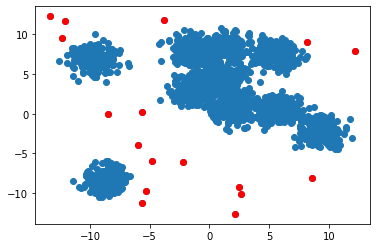

In [266]:
outliers = list()
for i in range(len(full_set_10_01)):
    ##distance threshold value set to 0.8
    if(neighbors[i][2] > 0.8) :
        outliers.append(i)
outlier_values_10_01 = full_set_10_01[outliers]


In [267]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in outlier_values_10_01:
  if row in finalOutliers_10_01:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 14
falsePositive: 3


In [268]:
match = 0
for row in finalOutliers_10_01:
  if row in outlier_values_10_01:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [270]:
KNN_10_01Precision = truePositive/(truePositive+falsePositive)
KNN_10_01Recall = truePositive/(truePositive+falseNegative)
KNN_10_01F1 = 2*((KNN_10_01Precision*KNN_10_01Recall)/(KNN_10_01Precision+KNN_10_01Recall))
print ("KNN_10_01Precision: {x}".format(x=KNN_10_01Precision))
print ("KNN_10_01Recall: {x}".format(x=KNN_10_01Recall))
print ("KNN_10_01F1: {x}".format(x=KNN_10_01F1))

KNN_10_01Precision: 0.8235294117647058
KNN_10_01Recall: 1.0
KNN_10_01F1: 0.9032258064516129


In [278]:
full_set_10_05.tolist()
neighbors = list()
for i in range(len(full_set_10_05)):

  neighbors.append((i,get_neighbors(full_set_10_05, full_set_10_05[i], 3),mean(get_neighbors(full_set_10_05, full_set_10_05[i], 3))))
  

In [285]:
outliers = list()
for i in range(len(full_set_10_05)):
    ##distance threshold value set to 0.8
    if(neighbors[i][2] > 0.8) :
        outliers.append(i)
outlier_values_10_05 = full_set_10_05[outliers]


In [286]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in outlier_values_10_05:
  if row in finalOutliers_10_05:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 12
falsePositive: 8


In [281]:
match = 0
for row in finalOutliers_10_05:
  if row in outlier_values_10_05:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [282]:
KNN_10_05Precision = truePositive/(truePositive+falsePositive)
KNN_10_05Recall = truePositive/(truePositive+falseNegative)
KNN_10_05F1 = 2*((KNN_10_05Precision*KNN_10_05Recall)/(KNN_10_05Precision+KNN_10_05Recall))
print ("KNN_10_05Precision: {x}".format(x=KNN_10_05Precision))
print ("KNN_10_05Recall: {x}".format(x=KNN_10_05Recall))
print ("KNN_10_05F1: {x}".format(x=KNN_10_05F1))

KNN_10_05Precision: 0.9523809523809523
KNN_10_05Recall: 1.0
KNN_10_05F1: 0.975609756097561


In [287]:
full_set_5_1.tolist()
neighbors = list()
for i in range(len(full_set_5_1)):

  neighbors.append((i,get_neighbors(full_set_5_1, full_set_5_1[i], 3),mean(get_neighbors(full_set_5_1, full_set_5_1[i], 3))))

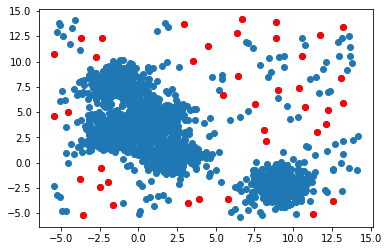

In [290]:
outliers = list()
for i in range(len(full_set_5_1)):
    ##distance threshold value set to 0.7
    if(neighbors[i][2] > 0.7) :
        outliers.append(i)
outlier_values_5_1 = full_set_5_1[outliers]

In [291]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in outlier_values_5_1:
  if row in finalOutliers_5_1:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 39
falsePositive: 1


In [292]:
match = 0
for row in finalOutliers_5_1:
  if row in outlier_values_5_1:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [293]:
KNN_5_1Precision = truePositive/(truePositive+falsePositive)
KNN_5_1Recall = truePositive/(truePositive+falseNegative)
KNN_5_1F1 = 2*((KNN_5_1Precision*KNN_5_1Recall)/(KNN_5_1Precision+KNN_5_1Recall))
print ("KNN_5_1Precision: {x}".format(x=KNN_5_1Precision))
print ("KNN_5_1Recall: {x}".format(x=KNN_5_1Recall))
print ("KNN_5_1F1: {x}".format(x=KNN_5_1F1))

KNN_5_1Precision: 0.975
KNN_5_1Recall: 1.0
KNN_5_1F1: 0.9873417721518987


In [294]:
full_set_5_01.tolist()
neighbors = list()
for i in range(len(full_set_5_01)):

  neighbors.append((i,get_neighbors(full_set_5_01, full_set_5_01[i], 3),mean(get_neighbors(full_set_5_01, full_set_5_01[i], 3))))

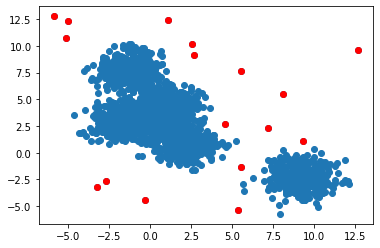

In [303]:
outliers = list()
for i in range(len(full_set_5_01)):
    ##distance threshold value set to 0.7
    if(neighbors[i][2] > 0.7) :
        outliers.append(i)
outlier_values_5_01 = full_set_5_01[outliers]


In [304]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in outlier_values_5_01:
  if row in finalOutliers_5_01:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 13
falsePositive: 4


In [305]:
match = 0
for row in finalOutliers_5_01:
  if row in outlier_values_5_01:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [306]:
KNN_5_01Precision = truePositive/(truePositive+falsePositive)
KNN_5_01Recall = truePositive/(truePositive+falseNegative)
KNN_5_01F1 = 2*((KNN_5_01Precision*KNN_5_01Recall)/(KNN_5_01Precision+KNN_5_01Recall))
print ("KNN_5_01Precision: {x}".format(x=KNN_5_01Precision))
print ("KNN_5_01Recall: {x}".format(x=KNN_5_01Recall))
print ("KNN_5_01F1: {x}".format(x=KNN_5_01F1))

KNN_5_01Precision: 0.7647058823529411
KNN_5_01Recall: 1.0
KNN_5_01F1: 0.8666666666666666


In [307]:
full_set_5_05.tolist()
neighbors = list()
for i in range(len(full_set_5_05)):

  neighbors.append((i,get_neighbors(full_set_5_05, full_set_5_05[i], 3),mean(get_neighbors(full_set_5_05, full_set_5_05[i], 3))))

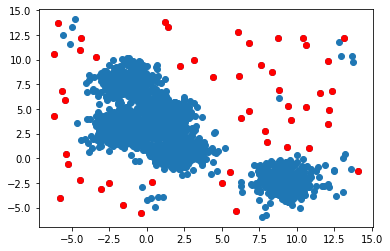

In [308]:
outliers = list()
for i in range(len(full_set_5_05)):
    ##distance threshold value set to 0.5
    if(neighbors[i][2] > 0.7) :
        outliers.append(i)
outlier_values_5_05 = full_set_5_05[outliers]


In [309]:
truePositive = 0
falsePositive = 0
falseNegative = 0
match = 0

for row in outlier_values_5_05:
  if row in finalOutliers_5_05:
    
    match = 1

  if match == 1:
    truePositive += 1
  else: 
    falsePositive += 1
  match = 0

print ("truePositive: {x}".format(x=truePositive))
print ("falsePositive: {x}".format(x=falsePositive))

truePositive: 48
falsePositive: 2


In [310]:
match = 0
for row in finalOutliers_5_05:
  if row in outlier_values_5_05:

    match = 1

    if match == 0:
      falseNegative += 1
    match = 0

print ("falseNegative: {x}".format(x=falseNegative))

falseNegative: 0


In [311]:
KNN_5_05Precision = truePositive/(truePositive+falsePositive)
KNN_5_05Recall = truePositive/(truePositive+falseNegative)
KNN_5_05F1 = 2*((KNN_5_05Precision*KNN_5_05Recall)/(KNN_5_05Precision+KNN_5_05Recall))
print ("KNN_5_05Precision: {x}".format(x=KNN_5_05Precision))
print ("KNN_5_05Recall: {x}".format(x=KNN_5_05Recall))
print ("KNN_5_05F1: {x}".format(x=KNN_5_05F1))

KNN_5_05Precision: 0.96
KNN_5_05Recall: 1.0
KNN_5_05F1: 0.9795918367346939


# **Results**

The results for both the OneClass SVM implementation and K NN implementation are displayed below. 

**SVM**

In [312]:
print ("SVM_10_1Precision: {x}".format(x=SVM_10_1Precision))
print ("SVM_10_1Recall: {x}".format(x=SVM_10_1Recall))
print ("SVM_10_1F1: {x}".format(x=SVM_10_1F1))
print("\n")
print ("SVM_10_01Precision: {x}".format(x=SVM_10_01Precision))
print ("SVM_10_01Recall: {x}".format(x=SVM_10_01Recall))
print ("SVM_10_01F1: {x}".format(x=SVM_10_01F1))
print("\n")
print ("SVM_10_05Precision: {x}".format(x=SVM_10_05Precision))
print ("SVM_10_05Recall: {x}".format(x=SVM_10_05Recall))
print ("SVM_10_05F1: {x}".format(x=SVM_10_05F1))
print("\n")
print ("SVM_5_1Precision: {x}".format(x=SVM_5_1Precision))
print ("SVM_5_1Recall: {x}".format(x=SVM_5_1Recall))
print ("SVM_5_1F1: {x}".format(x=SVM_5_1F1))
print("\n")
print ("SVM_5_01Precision: {x}".format(x=SVM_5_01Precision))
print ("SVM_5_01Recall: {x}".format(x=SVM_5_01Recall))
print ("SVM_5_01F1: {x}".format(x=SVM_5_01F1))
print("\n")
print ("SVM_5_05Precision: {x}".format(x=SVM_5_05Precision))
print ("SVM_5_05Recall: {x}".format(x=SVM_5_05Recall))
print ("SVM_5_05F1: {x}".format(x=SVM_5_05F1))

SVM_10_1Precision: 0.8166666666666667
SVM_10_1Recall: 1.0
SVM_10_1F1: 0.8990825688073394


SVM_10_01Precision: 0.625
SVM_10_01Recall: 1.0
SVM_10_01F1: 0.7692307692307693


SVM_10_05Precision: 0.95
SVM_10_05Recall: 1.0
SVM_10_05F1: 0.9743589743589743


SVM_5_1Precision: 0.875
SVM_5_1Recall: 1.0
SVM_5_1F1: 0.9333333333333333


SVM_5_01Precision: 0.75
SVM_5_01Recall: 1.0
SVM_5_01F1: 0.8571428571428571


SVM_5_05Precision: 0.95
SVM_5_05Recall: 1.0
SVM_5_05F1: 0.9743589743589743


**K NN**

In [313]:
print ("KNN_10_1Precision: {x}".format(x=KNN_10_1Precision))
print ("KNN_10_1Recall: {x}".format(x=KNN_10_1Recall))
print ("KNN_10_1F1: {x}".format(x=KNN_10_1F1))
print("\n")
print ("KNN_10_01Precision: {x}".format(x=KNN_10_01Precision))
print ("KNN_10_01Recall: {x}".format(x=KNN_10_01Recall))
print ("KNN_10_01F1: {x}".format(x=KNN_10_01F1))
print("\n")
print ("KNN_10_05Precision: {x}".format(x=KNN_10_05Precision))
print ("KNN_10_05Recall: {x}".format(x=KNN_10_05Recall))
print ("KNN_10_05F1: {x}".format(x=KNN_10_05F1))
print("\n")
print ("KNN_5_1Precision: {x}".format(x=KNN_5_1Precision))
print ("KNN_5_1Recall: {x}".format(x=KNN_5_1Recall))
print ("KNN_5_1F1: {x}".format(x=KNN_5_1F1))
print("\n")
print ("KNN_5_01Precision: {x}".format(x=KNN_5_01Precision))
print ("KNN_5_01Recall: {x}".format(x=KNN_5_01Recall))
print ("KNN_5_01F1: {x}".format(x=KNN_5_01F1))
print("\n")
print ("KNN_5_05Precision: {x}".format(x=KNN_5_05Precision))
print ("KNN_5_05Recall: {x}".format(x=KNN_5_05Recall))
print ("KNN_5_05F1: {x}".format(x=KNN_5_05F1))
print("\n")

KNN_10_1Precision: 0.9206349206349206
KNN_10_1Recall: 1.0
KNN_10_1F1: 0.9586776859504132


KNN_10_01Precision: 0.8235294117647058
KNN_10_01Recall: 1.0
KNN_10_01F1: 0.9032258064516129


KNN_10_05Precision: 0.9523809523809523
KNN_10_05Recall: 1.0
KNN_10_05F1: 0.975609756097561


KNN_5_1Precision: 0.975
KNN_5_1Recall: 1.0
KNN_5_1F1: 0.9873417721518987


KNN_5_01Precision: 0.7647058823529411
KNN_5_01Recall: 1.0
KNN_5_01F1: 0.8666666666666666


KNN_5_05Precision: 0.96
KNN_5_05Recall: 1.0
KNN_5_05F1: 0.9795918367346939




# **Comparison of Results**

Displayed above are the precision, recall and f1 measure for the implementation of OneClass SVM and K NN on all 6 variations of the generated data set. The threshold values for both implementations were decided upon after some messing around with values. This was in order to maximize the resulting values and produce high quality outlier detection. We can see from above, that the K NN outlier detection has overall higher scores for most cases compared to the OneClass SVM implementation. We also can notice in the scatter plots that the OneClass SVm method neglects the outliers between the clusters of points and only takes into account outliers around the edges. On the other hand, the K NN implementation does not do this and therefore has higher values. The threshold values could have been adjusted abit more in order to produce better results. The K-NN script written could have been written to be more accurate to the ground truth and instead of the mean values being considered, a value more robust could have been chosen, for example z score.

